In [1]:
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from sklearn.metrics import f1_score
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
ds = load_dataset(
    "mikkoim/aquamonitor-jyu",
    cache_dir="/kaggle/working/"
)

hf_hub_download(
    repo_id="mikkoim/aquamonitor-jyu",
    filename="aquamonitor-jyu.parquet.gzip",
    repo_type="dataset",
    local_dir="/kaggle/working/"
)

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

train.tar:   0%|          | 0.00/143M [00:00<?, ?B/s]

val.tar:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6394 [00:00<?, ? examples/s]

aquamonitor-jyu.parquet.gzip:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

'/kaggle/working/aquamonitor-jyu.parquet.gzip'

{'__key__': '2_2-B6-Ch-ala1-6_1_2023_07_05-12-24-06-895', '__url__': '/root/.cache/huggingface/hub/datasets--mikkoim--aquamonitor-jyu/snapshots/e8f44a88890e94014d79e05a7936d63083aeba34/images/train.tar', 'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=248x256 at 0x7DB1F680AF50>} 

2_2-B6-Ch-ala1-6_1_2023_07_05-12-24-06-895


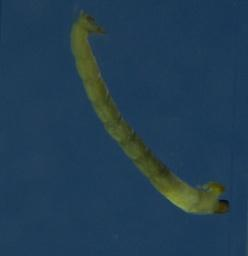

In [3]:
# dataset elements can be accessed with indices. Each "row" or record
# has an image and a key that can be used to access data from the metadata table
record = ds["train"][21015]
print(record, "\n")

img = record["jpg"]
print(record["__key__"])
img

In [4]:
# The keys match the rows in the metadata table
metadata = pd.read_parquet("/kaggle/working/aquamonitor-jyu.parquet.gzip")
metadata

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,img,individual,imaging_run,taxon,taxon_group,taxon_label,taxon_code,lake,site,sample,...,plate_weight,total_weight,caddisfly_without_shell,kingdom,phylum,class,order,family,genus,species
0,1_2-A1-Le-ala1-1_1_2023_07_04-15-11-01-271.jpg,2-A1-Le-ala1-1,2-A1-Le-ala1-1_1,Leptophlebia,Leptophlebia,Leptophlebia,Le,alajarvi,ala1,Le-ala1,...,210.2185,210.3485,NaN,Animalia,Arthropoda,Insecta,Ephemeroptera,Leptophlebiidae,Leptophlebia,None
1,1_2-A1-Le-ala1-1_1_2023_07_04-15-11-01-320.jpg,2-A1-Le-ala1-1,2-A1-Le-ala1-1_1,Leptophlebia,Leptophlebia,Leptophlebia,Le,alajarvi,ala1,Le-ala1,...,210.2185,210.3485,NaN,Animalia,Arthropoda,Insecta,Ephemeroptera,Leptophlebiidae,Leptophlebia,None
2,1_2-A1-Le-ala1-1_1_2023_07_04-15-11-01-394.jpg,2-A1-Le-ala1-1,2-A1-Le-ala1-1_1,Leptophlebia,Leptophlebia,Leptophlebia,Le,alajarvi,ala1,Le-ala1,...,210.2185,210.3485,NaN,Animalia,Arthropoda,Insecta,Ephemeroptera,Leptophlebiidae,Leptophlebia,None
3,1_2-A1-Le-ala1-1_1_2023_07_04-15-11-01-447.jpg,2-A1-Le-ala1-1,2-A1-Le-ala1-1_1,Leptophlebia,Leptophlebia,Leptophlebia,Le,alajarvi,ala1,Le-ala1,...,210.2185,210.3485,NaN,Animalia,Arthropoda,Insecta,Ephemeroptera,Leptophlebiidae,Leptophlebia,None
4,1_2-A1-Le-ala1-1_1_2023_07_04-15-11-01-505.jpg,2-A1-Le-ala1-1,2-A1-Le-ala1-1_1,Leptophlebia,Leptophlebia,Leptophlebia,Le,alajarvi,ala1,Le-ala1,...,210.2185,210.3485,NaN,Animalia,Arthropoda,Insecta,Ephemeroptera,Leptophlebiidae,Leptophlebia,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58461,2_17-H12-Ch-kur2-1_1_2023_08_31-13-00-27-295.jpg,17-H12-Ch-kur2-1,17-H12-Ch-kur2-1_1,Chironomidae,Chironomidae,Chironomidae,Ch,kuortaneenjarvi,kur2,Ch-kur2,...,209.1370,210.9980,NaN,Animalia,Arthropoda,Insecta,Diptera,Chironomidae,None,None
58462,2_17-H12-Ch-kur2-1_1_2023_08_31-13-00-27-323.jpg,17-H12-Ch-kur2-1,17-H12-Ch-kur2-1_1,Chironomidae,Chironomidae,Chironomidae,Ch,kuortaneenjarvi,kur2,Ch-kur2,...,209.1370,210.9980,NaN,Animalia,Arthropoda,Insecta,Diptera,Chironomidae,None,None
58463,2_17-H12-Ch-kur2-1_1_2023_08_31-13-00-27-350.jpg,17-H12-Ch-kur2-1,17-H12-Ch-kur2-1_1,Chironomidae,Chironomidae,Chironomidae,Ch,kuortaneenjarvi,kur2,Ch-kur2,...,209.1370,210.9980,NaN,Animalia,Arthropoda,Insecta,Diptera,Chironomidae,None,None
58464,2_17-H12-Ch-kur2-1_1_2023_08_31-13-00-27-379.jpg,17-H12-Ch-kur2-1,17-H12-Ch-kur2-1_1,Chironomidae,Chironomidae,Chironomidae,Ch,kuortaneenjarvi,kur2,Ch-kur2,...,209.1370,210.9980,NaN,Animalia,Arthropoda,Insecta,Diptera,Chironomidae,None,None


In [5]:
classes = sorted(metadata["taxon_group"].unique())
class_map = {k:v for v,k in enumerate(classes)}
class_map_inv = {v:k for k,v in class_map.items()}

metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))

class_map_inv

{0: 'Asellus aquaticus',
 1: 'Caenis horaria',
 2: 'Caenis luctuosa',
 3: 'Ceratopogonidae',
 4: 'Chironomidae',
 5: 'Cloeon dipterum',
 6: 'Cyrnus flavidus',
 7: 'Ecnomus tenellus',
 8: 'Ephemera vulgata',
 9: 'Erpobdella octoculata',
 10: 'Gyraulus',
 11: 'Helobdella stagnalis',
 12: 'Heptagenia dalecarlica',
 13: 'Hydrachnidia',
 14: 'Hydroptila',
 15: 'Kageronia fuscogrisea',
 16: 'Lepidostoma hirtum',
 17: 'Leptophlebia',
 18: 'Limnephilidae',
 19: 'Limnephilus',
 20: 'Micronecta',
 21: 'Mystacides azurea',
 22: 'Oligochaeta',
 23: 'Oulimnius tuberculatus',
 24: 'Oulimnius tuberculatus adult',
 25: 'Pisidium',
 26: 'Psychomyia pusilla',
 27: 'Spirosperma ferox',
 28: 'Stylaria lacustris',
 29: 'Tanypodinae',
 30: 'Tinodes waeneri'}

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH_NUM = 20

In [7]:
tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#    transforms.RandomHorizontalFlip(p=0.75),
#    transforms.RandomRotation(degrees=10),
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess(batch):
    return {"key": batch["__key__"],
            "img": [tf(x) for x in batch["jpg"]],
            "label": torch.as_tensor([label_dict[x] for x in batch["__key__"]], dtype=torch.long)}

train_ds = ds["train"].with_transform(preprocess)
devel_ds = ds["validation"].with_transform(preprocess)

print(f"Train Size: {train_ds.num_rows}")
print(f"Devel Size: {devel_ds.num_rows}")

# plt.imshow(train_ds[2014]["img"].permute(1, 2, 0).numpy())

Train Size: 40880
Devel Size: 6394


In [8]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

devel_loader = DataLoader(
    devel_ds,
    batch_size=BATCH_SIZE
)

In [9]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(
    in_features=model.fc.in_features,
    out_features=len(classes)
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [10]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#    optimizer,
#    mode="min",
#    factor=0.5,
#    patience=5
#)

#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#    optimizer,
#    T_0=3,
#    T_mult=1,
#    eta_min=1e-5
#)

#scheduler = optim.lr_scheduler.CyclicLR(
#    optimizer,
#    base_lr=1e-5,
#    max_lr=1e-4,
#    step_size_up=3,
#    step_size_down=3,
#    mode="triangular"
#)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialise objects to store results
train_losses = []
train_f1s = []
devel_losses = []
devel_f1s = []
best_loss = float("inf")
best_model_weights = None

for epoch in range(EPOCH_NUM):

    model.train()
    running_loss = 0.0
    train_labels = []
    train_preds = []
    
    for batch in train_loader:
        images, labels = batch["img"], batch["label"]
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Store predictions
        _, preds = torch.max(outputs.data, 1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())
    
    # Calculate and store training loss and f1 score
    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

    # Validation phase
    model.eval()
    devel_running_loss = 0.0
    devel_labels = []
    devel_preds = []
    
    with torch.no_grad():
        for batch in devel_loader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            devel_running_loss += loss.item()
            
            # Store predictions
            _, preds = torch.max(outputs.data, 1)
            devel_labels.extend(labels.cpu().numpy())
            devel_preds.extend(preds.cpu().numpy())
    
    # Calculate and store validation loss and f1 score
    devel_loss = devel_running_loss / len(devel_loader)
    devel_f1 = f1_score(devel_labels, devel_preds, average="weighted")
    devel_losses.append(devel_loss)
    devel_f1s.append(devel_f1)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCH_NUM}], lr: {scheduler.get_last_lr()[0]}, "
          f"Train Loss: {train_loss:.4f}, Train F1-Score: {train_f1:.3g}, "
          f"Devel Loss: {devel_loss:.4f}, Devel F1-Score: {devel_f1:.3g}")

    # Check if we have a new best model
    if devel_loss < best_loss:
        best_loss = devel_loss
        best_model_weights = model.state_dict()

Epoch [1/20], lr: 0.0001, Train Loss: 2.4689, Train F1-Score: 0.35, Devel Loss: 2.0282, Devel F1-Score: 0.503
Epoch [2/20], lr: 0.0001, Train Loss: 1.6112, Train F1-Score: 0.657, Devel Loss: 1.6543, Devel F1-Score: 0.617
Epoch [3/20], lr: 0.0001, Train Loss: 1.2726, Train F1-Score: 0.798, Devel Loss: 1.5057, Devel F1-Score: 0.66
Epoch [4/20], lr: 0.0001, Train Loss: 1.0860, Train F1-Score: 0.88, Devel Loss: 1.4368, Devel F1-Score: 0.678
Epoch [5/20], lr: 5e-05, Train Loss: 0.9625, Train F1-Score: 0.931, Devel Loss: 1.4521, Devel F1-Score: 0.685
Epoch [6/20], lr: 5e-05, Train Loss: 0.8963, Train F1-Score: 0.958, Devel Loss: 1.4209, Devel F1-Score: 0.691
Epoch [7/20], lr: 5e-05, Train Loss: 0.8640, Train F1-Score: 0.971, Devel Loss: 1.4250, Devel F1-Score: 0.693
Epoch [8/20], lr: 5e-05, Train Loss: 0.8397, Train F1-Score: 0.978, Devel Loss: 1.4192, Devel F1-Score: 0.697
Epoch [9/20], lr: 5e-05, Train Loss: 0.8192, Train F1-Score: 0.983, Devel Loss: 1.4312, Devel F1-Score: 0.697
Epoch [10

In [12]:
# Restore best weights
if best_model_weights is not None:

    # Load best model
    model.load_state_dict(best_model_weights)
    # Save best model
    torch.save(best_model_weights, "/kaggle/working/fine_tuned_resnet18.pth")

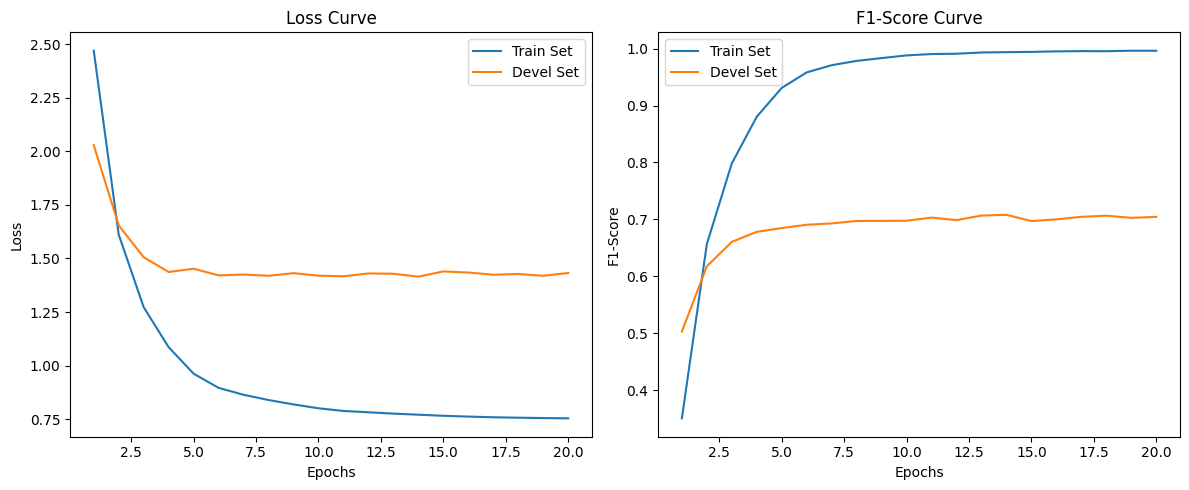

In [13]:
# Plot the learning curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCH_NUM + 1), train_losses, label="Train Set")
plt.plot(range(1, EPOCH_NUM + 1), devel_losses, label="Devel Set")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# F1-Score plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCH_NUM + 1), train_f1s, label="Train Set")
plt.plot(range(1, EPOCH_NUM + 1), devel_f1s, label="Devel Set")
plt.title("F1-Score Curve")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()

plt.tight_layout()